In [6]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read all words

words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

Vocab

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


Dataset

In [7]:
block_size = 3

def build_dataset(words):

    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


MLP params

In [8]:
n_embed = 10 #embedding dimensions
n_hidden = 200 #no of neurons in the hidden layer

g = torch.Generator().manual_seed(42)

C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # total no of params
for p in parameters:
    p.requires_grad = True

11897


Optimization

In [12]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix] #batch X, Y

    #forward pass
    emb = C[Xb] #embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)
    h_pre_act = embcat @ W1 + b1
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #learning rate
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay

    #update
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())


      0/ 200000: 28.1707
  10000/ 200000: 2.2835
  20000/ 200000: 2.8634
  30000/ 200000: 2.1481
  40000/ 200000: 2.6488


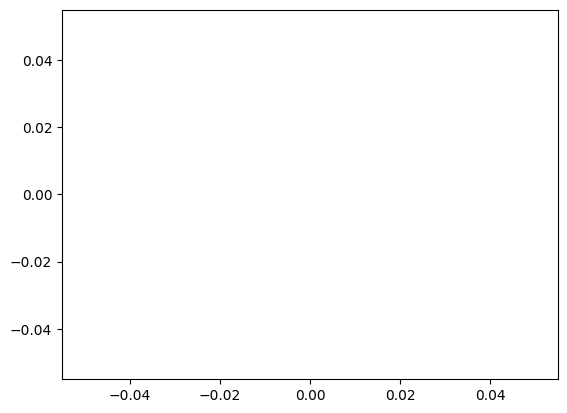

In [11]:
plt.plot(lossi)

Eval

In [ ]:
@torch.no_grad() #disable grad tracking
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]

    emb = C[x] #(N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size*n_embed)
    h = torch.tanh(embcat@ W1 + b1)
    logits = h @ W2 +b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
    